# Did you perceive the tinnitus right now? 
## Analysis grouped by country and continent

In [25]:
# project location
p_loc = 'C:/Users/joa24jm/Documents/tinnitus-country/'

# add src to path so the noteboook can import utilities.py
import sys
sys.path.append('C:\\Users\\joa24jm\\Documents\\tinnitus-country\\src\\')

In [26]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from d00_utils import utilities as u

In [27]:
# read in intermediate dataframe merged_users
df = pd.read_csv(p_loc + 'data/02_intermediate/merged_users.csv', index_col = 'Unnamed: 0')

In [28]:
df.user_id.value_counts()

2427.0    4399
2481.0    2220
5927.0    2165
1252.0    1596
2588.0    1580
          ... 
6455.0       1
671.0        1
3474.0       1
5144.0       1
1174.0       1
Name: user_id, Length: 3691, dtype: int64

In [29]:
df.fup_answer_from

0        2014-04-24 15:31:23
1        2014-04-23 07:45:12
2        2014-04-23 07:56:18
3        2014-04-23 09:21:14
4        2014-04-23 09:21:36
                ...         
97737    2021-02-22 03:33:08
97738    2021-02-22 15:57:16
97739                    NaN
97740    2021-02-22 02:42:59
97741    2021-02-22 11:06:29
Name: fup_answer_from, Length: 97742, dtype: object

In [30]:
# replace column names and values for better readability
df.rename(columns = {'question1': 'Tinnitus_right_now'}, inplace = True)
df.Tinnitus_right_now.replace({0.0:'No', 1.0:'Yes'}, inplace = True)

In [31]:
# generate a crosstab and save it as 'ct'
ct = pd.crosstab(df.Continent_Name, df.Tinnitus_right_now)
ct

Tinnitus_right_now,No,Yes
Continent_Name,,
Africa,105,371
Antarctica,2,0
Asia,638,2676
Europe,17462,58748
North America,1816,10505
Oceania,155,1526
South America,241,1180


In [32]:
# stack results and rename for better readability
stacked = ct.stack().reset_index().rename(columns={0:'value'})
stacked.Continent_Name.replace({'North America':'North\nAmerica', 'South America':'South\nAmerica'}, inplace = True)

In [33]:
stacked

,Continent_Name,Tinnitus_right_now,value
0,Africa,No,105
1,Africa,Yes,371
2,Antarctica,No,2
3,Antarctica,Yes,0
4,Asia,No,638
5,Asia,Yes,2676
6,Europe,No,17462
7,Europe,Yes,58748
8,North\nAmerica,No,1816
9,North\nAmerica,Yes,10505


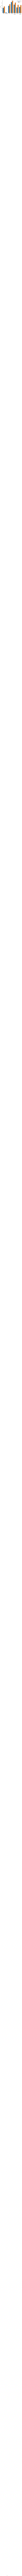

In [34]:
# create plot and add annotations
fig, ax = plt.subplots(1,1)

# remove top and right frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.barplot(x= stacked.Continent_Name, y = stacked.value, hue = stacked.Tinnitus_right_now, ax = ax)

# set log scale and labels
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('Count')

# show values on bars
u.show_values_on_bars(ax, h_v = 'v', space = 1)


## Plot tinnitus_right_now per country on a horizontal barplot

In [37]:
# generate a crosstab and save it as 'ct'
ct = pd.crosstab(df.Country_Name, df.Tinnitus_right_now, normalize = False)
# get the top 20 countries for tinnitus=YES
ct = ct.sort_values('Yes', ascending = False).iloc[:20,]

ct

Tinnitus_right_now,No,Yes
Country_Name,,
"Germany, Federal Republic of",10789,40495
United States of America,1206,8218
"Netherlands, Kingdom of the",2388,4833
"Switzerland, Swiss Confederation",1677,3429
United Kingdom of Great Britain & Northern Ireland,755,2919
Russian Federation,24,2264
Canada,322,1989
"Italy, Italian Republic",53,1147
New Zealand,59,963


In [53]:
# get the n questionnaires per country
ct.sum(axis = 1).sort_index()


Country_Name
Argentina, Argentine Republic                           778
Australia, Commonwealth of                              653
Austria, Republic of                                   1306
Belgium, Kingdom of                                     964
Brazil, Federative Republic of                          334
Cambodia, Kingdom of                                    968
Canada                                                 2311
France, French Republic                                 453
Germany, Federal Republic of                          51284
Italy, Italian Republic                                1200
Netherlands, Kingdom of the                            7221
New Zealand                                            1022
Norway, Kingdom of                                     1161
Portugal, Portuguese Republic                           458
Russian Federation                                     2288
South Africa, Republic of                               414
Spain, Kingdom of          

In [66]:
df[df.Country_Name == 'Cambodia, Kingdom of'].shape

(968, 65)

In [43]:
# get ct with normalized values for these countries
countries = ct.index.tolist()
sub_df = df[df.Country_Name.isin(countries)]
ct2 = pd.crosstab(sub_df.Country_Name, sub_df.Tinnitus_right_now, normalize = 'index')
ct2.style.format('{:,.2%}')

Tinnitus_right_now,No,Yes
Country_Name,,
"Argentina, Argentine Republic",20.57%,79.43%
"Australia, Commonwealth of",14.55%,85.45%
"Austria, Republic of",29.56%,70.44%
"Belgium, Kingdom of",28.63%,71.37%
"Brazil, Federative Republic of",8.68%,91.32%
"Cambodia, Kingdom of",21.28%,78.72%
Canada,13.93%,86.07%
"France, French Republic",16.56%,83.44%
"Germany, Federal Republic of",21.04%,78.96%


In [64]:
# how many users per country?
sub_df.groupby('Country_Name')['user_id'].nunique()

Country_Name
Argentina, Argentine Republic                           19
Australia, Commonwealth of                              77
Austria, Republic of                                    68
Belgium, Kingdom of                                     44
Brazil, Federative Republic of                          50
Cambodia, Kingdom of                                     1
Canada                                                 126
France, French Republic                                 72
Germany, Federal Republic of                          1410
Italy, Italian Republic                                 81
Netherlands, Kingdom of the                            180
New Zealand                                             17
Norway, Kingdom of                                      42
Portugal, Portuguese Republic                           18
Russian Federation                                      16
South Africa, Republic of                               10
Spain, Kingdom of                          

In [19]:
# stack results and rename for better readability
stacked = ct.stack().reset_index().rename(columns={0:'value'})
stacked

,Country_Name,Tinnitus_right_now,value
0,"Germany, Federal Republic of",No,10789
1,"Germany, Federal Republic of",Yes,40495
2,United States of America,No,1206
3,United States of America,Yes,8218
4,"Netherlands, Kingdom of the",No,2388
5,"Netherlands, Kingdom of the",Yes,4833
6,"Switzerland, Swiss Confederation",No,1677
7,"Switzerland, Swiss Confederation",Yes,3429
8,United Kingdom of Great Britain & Northern Ire...,No,755
9,United Kingdom of Great Britain & Northern Ire...,Yes,2919


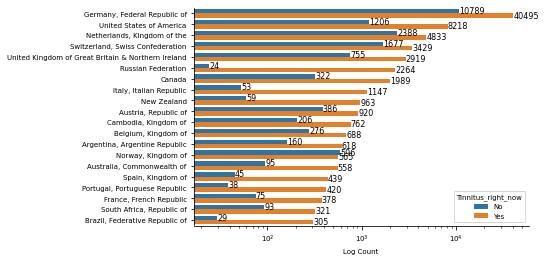

In [20]:
# decrease font size
matplotlib.rcParams.update({'font.size': 7})

# create plot and add annotations
fig, ax = plt.subplots(1,1)

# remove top and right frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.barplot(y= stacked.Country_Name, x = stacked.value, hue = stacked.Tinnitus_right_now, ax = ax,
            orient = 'h')

# set log scale and labels
ax.set_xscale('log')
ax.set_xlabel('Log Count')
ax.set_ylabel('')

# show values on bars
u.show_values_on_bars(ax, h_v = 'h', space = 0.4)

# safe ylabels as reference for normalized bar plot
ylabels = [label.get_text() for label in ax.get_yticklabels()]


In [21]:
# generate a crosstab and save it as 'ct'
ct = pd.crosstab(df.Country_Name, df.Tinnitus_right_now, normalize = 'index')
# get the top 20 countries for tinnitus=YES
ct = ct.loc[ylabels,]

In [22]:
ct

Tinnitus_right_now,No,Yes
Country_Name,,
"Germany, Federal Republic of",0.210378,0.789622
United States of America,0.127971,0.872029
"Netherlands, Kingdom of the",0.330702,0.669298
"Switzerland, Swiss Confederation",0.328437,0.671563
United Kingdom of Great Britain & Northern Ireland,0.205498,0.794502
Russian Federation,0.010490,0.989510
Canada,0.139334,0.860666
"Italy, Italian Republic",0.044167,0.955833
New Zealand,0.057730,0.942270


In [13]:
# stack results and rename for better readability
stacked = ct.stack().reset_index().rename(columns={0:'value'})

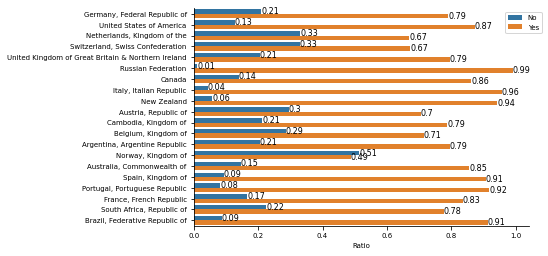

In [14]:
# decrease font size
matplotlib.rcParams.update({'font.size': 7})

# create plot and add annotations
fig, ax = plt.subplots(1,1)

# remove top and right frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.barplot(y= stacked.Country_Name, x = stacked.value, hue = stacked.Tinnitus_right_now, ax = ax,
            orient = 'h')

# set log scale and labels
ax.set_xlabel('Ratio')
ax.set_ylabel('')

ax.legend(bbox_to_anchor=(1.05,1))

# show values on bars
u.show_values_on_bars(ax, h_v = 'h', space = 0.4, normalize = True)

# safe ylabels as reference for normalized bar plot
ylabels = [label.get_text() for label in ax.get_yticklabels()]